### **Importing Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.exceptions import ConvergenceWarning
from imblearn.over_sampling import RandomOverSampler

### **Data Preprocessing**

**Reading the dataset**

In [ ]:
dataset = pd.read_csv('weatherAUS.csv')
dataset.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


**Dropping 'Date' column**

1. Date does not contribute much for classification

In [ ]:
dataset = dataset.drop(columns = ['Date'])

**Separating Numerical and Categorical features.**

In [ ]:
categorical_features = dataset.select_dtypes(include = ['object']).columns.tolist()
numerical_features = dataset.select_dtypes(include = ['float64']).columns.tolist()

print("Numerical Features\n\n", numerical_features, "\n")
print("Categorical Features\n\n", categorical_features, "\n")

Numerical Features

 ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm'] 

Categorical Features

 ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow'] 



**Handling Null values**

1. Dropping the rows containing NaN values in Categorical columns.
2. Imputing the Numerical columns containing NaN with 'mean' strategy.

In [ ]:
print("Percentage of NaN before handling Null values\n\n",round(dataset.isna().mean() * 100, 2), "\n")

dataset.dropna(axis=0, subset=categorical_features, inplace=True)

dtst = dataset.iloc[:,:].values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(dtst[:, 1:3])
dtst[:, 1:3] = imputer.transform(dtst[:, 1:3])
imputer.fit(dtst[:, 4:6])
dtst[:, 4:6] = imputer.transform(dtst[:, 4:6])
imputer.fit(dtst[:, 12:20])
dtst[:, 12:20] = imputer.transform(dtst[:, 12:20])

Percentage of NaN before handling Null values

 Location          0.00
MinTemp           1.02
MaxTemp           0.87
Rainfall          2.24
Evaporation      43.17
Sunshine         48.01
WindGustDir       7.10
WindGustSpeed     7.06
WindDir9am        7.26
WindDir3pm        2.91
WindSpeed9am      1.21
WindSpeed3pm      2.11
Humidity9am       1.82
Humidity3pm       3.10
Pressure9am      10.36
Pressure3pm      10.33
Cloud9am         38.42
Cloud3pm         40.81
Temp9am           1.21
Temp3pm           2.48
RainToday         2.24
RainTomorrow      2.25
dtype: float64 



**Transforming the NumPy array into DataFrame.**

In [ ]:
dataset = pd.DataFrame(dtst)
dataset.rename(columns={0: 'Location', 1: 'MinTemp', 2: 'MaxTemp', 3: 'Rainfall', 4: 'Evaporation', 5: 'Sunshine', 6: 'WindGustDir', 7: 'WindGustSpeed', 8: 'WindDir9am', 9: 'WindDir3pm', 10: 'WindSpeed9am', 11: 'WindSpeed3pm', 12: 'Humidity9am', 13: 'Humidity3pm', 14: 'Pressure9am', 15: 'Pressure3pm', 16: 'Cloud9am', 17: 'Cloud3pm', 18: 'Temp9am' , 19: 'Temp3pm', 20: 'RainToday', 21: 'RainTomorrow'}, inplace=True)
dataset_copy = dataset.copy()

print("Percentage of NaN after handling Null values\n\n",round(dataset.isna().mean() * 100, 2), "\n")

Percentage of NaN after handling Null values

 Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
dtype: float64 



**Handling outliers using Winsorization**

1. Winsorization is a technique of capping the values that do not lie between the specified percentile (Here they are 5% and 95%).

In [ ]:
def winsorize_feature(feature, lower_percentile=5, upper_percentile=95):
    lower_bound = np.percentile(feature, lower_percentile)
    upper_bound = np.percentile(feature, upper_percentile)

    feature[feature < lower_bound] = lower_bound
    feature[feature > upper_bound] = upper_bound

    return feature

for feature in numerical_features:
    dataset[feature] = winsorize_feature(dataset[feature])

**Encoding the Categorical columns**

1. Applying Label Encoding to 'RainToday' and 'RainTomorrow' since they have only 2 unique values (Yes and No).
2. Applying One-Hot Encoding to other Categorical columns since they contain more than 2 unique values.

In [ ]:
label_encoder = LabelEncoder()
for i in categorical_features[4:]:
  dataset[i] = label_encoder.fit_transform(dataset[i])
dataset = pd.get_dummies(dataset, columns = categorical_features[0:4])

dataset.head(5)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,13.4,22.9,0.6,5.609501,7.718384,44.0,20.0,24.0,71.0,22.0,...,0,0,0,0,0,0,0,0,1,0
1,7.4,25.1,0.0,5.609501,7.718384,44.0,4.0,22.0,44.0,25.0,...,0,0,0,0,0,0,0,0,0,1
2,12.9,25.7,0.0,5.609501,7.718384,46.0,19.0,26.0,38.0,30.0,...,0,0,0,0,0,0,0,0,0,1
3,9.2,28.0,0.0,5.609501,7.718384,24.0,11.0,9.0,45.0,16.0,...,0,0,0,0,0,0,0,0,0,0
4,17.5,32.3,1.0,5.609501,7.718384,41.0,7.0,20.0,82.0,33.0,...,0,1,0,0,0,0,0,0,0,0


### **Train Test Split**

In [ ]:
X = dataset.drop(columns = ['RainTomorrow'])
y = dataset['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 37)

warnings.filterwarnings("ignore", category=ConvergenceWarning)

### **Logistic Regression**

**Fitting the model and predicting**

In [ ]:
logistic_classifier = LogisticRegression(max_iter = 1500, solver = 'liblinear')
logistic_classifier.fit(X_train, y_train)

y_pred = logistic_classifier.predict(X_test)

**Confusion Matrix and HeatMap**

Confusion Matrix

 [[22666  1382]
 [ 3308  3572]] 



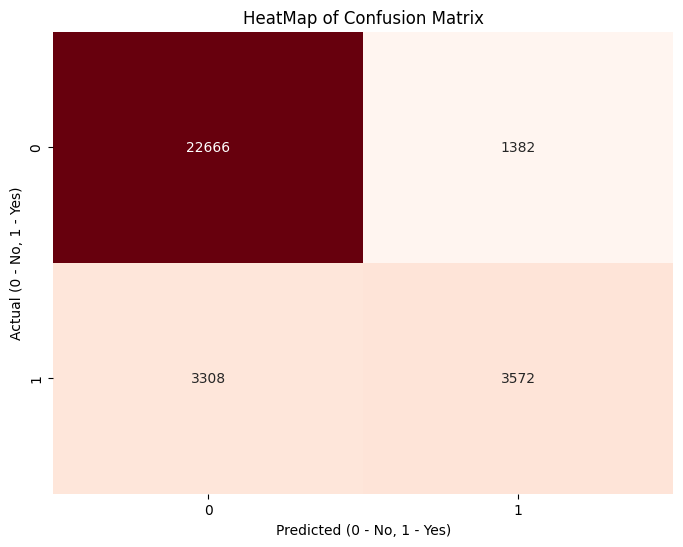

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n\n", cm, "\n")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='g', cbar=False)
plt.xlabel('Predicted (0 - No, 1 - Yes)')
plt.ylabel('Actual (0 - No, 1 - Yes)')
plt.title('HeatMap of Confusion Matrix')
plt.show()

**Classification Report and Accuracy score**

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

acc_score = accuracy_score(y_test, y_pred)
print("Accuracy Score: ", round(acc_score*100, 2), "%")

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91     24048
           1       0.72      0.52      0.60      6880

    accuracy                           0.85     30928
   macro avg       0.80      0.73      0.75     30928
weighted avg       0.84      0.85      0.84     30928

Accuracy Score:  84.84 %


**ROC Curve and finding Optimal Threshold**

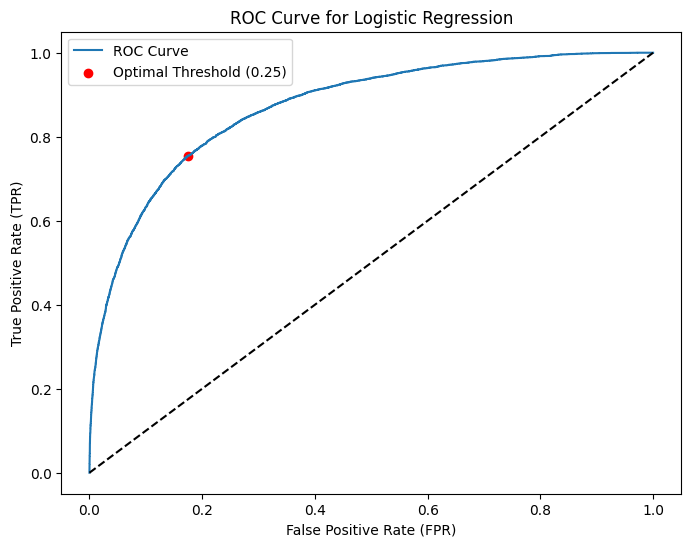

ROC-AUC Score:  87.12
Optimal Threshold:  0.25


In [ ]:
y_prob = logistic_classifier.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test.values, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Logistic Regression')

roc_auc = roc_auc_score(y_test, y_prob)
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]

plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], marker='o', color='red', label=f'Optimal Threshold ({optimal_threshold:.2f})')

plt.legend()
plt.show()

print("ROC-AUC Score: ", round(roc_auc*100, 2))
print("Optimal Threshold: ", round(optimal_threshold, 2))

y_pred_adjusted = (y_prob >= optimal_threshold).astype(int)

**Accuracy Score after adjusting threshold**

In [ ]:
acc_score = accuracy_score(y_test, y_pred_adjusted)
print("Accuracy Score: ", round(acc_score*100, 2), "%")

Accuracy Score:  81.0 %


**Inference after adjusting the threshold**

1. Adjusting the threshold changes the balance between true positives and true negatives.
2. This causes a reduction in accuracy score.

**Cross Validation with k-folds**

1. Testing with k = 3.

In [ ]:
k = 3

cv_scores = cross_val_score(logistic_classifier, X, y, cv=k)

mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", mean_cv_score)
print("Standard Deviation of CV Scores:", std_cv_score)

Cross-Validation Scores: [0.82537527 0.79617819 0.84368028]
Mean CV Score: 0.8217445795465186
Standard Deviation of CV Scores: 0.019561843290319264


**Inference after k-fold analysis**

1. 3-fold analysis produces scores that are close to the initial model accuracy, but does not produce scores greater than the initial score.

**Test for overfit or underfit**

In [ ]:
print(f"Training set score: {logistic_classifier.score(X_train, y_train):0.4f}")
print(f"Testing set score: {logistic_classifier.score(X_test,y_test):.4f}")

Training set score: 0.8538
Testing set score: 0.8484


1. Since training set score is larger than testing set score, it causes over-fitting.
2. Since it is just a small difference in accuracy, It does not contribute to significant amount of over-fitting.

**Optimizing Regularization parameter**

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(logistic_classifier, param_grid, cv=3)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Regularization Hyperparameter:", best_params)

best_model = grid_search.best_estimator_
best_model_performance = best_model.score(X_test, y_test)
print("Model Performance with Best Hyperparameter:", round(best_model_performance*100, 2), "%")

Best Regularization Hyperparameter: {'C': 1}
Model Performance with Best Hyperparameter: 84.84 %


**Inference for tuning Regularization parameter**

1. Optimal Regularization parameter is chosen and the accuracy score is increased by around 0.1%.

### **Logistic Regression with Balanced Dataset**

**Train Test Split with Balancing using OverSampler**

1. The RandomOverSampler is a technique used in handling imbalanced datasets, specifically in the context of classification problems where one class is significantly underrepresented compared to the others.
2. It addresses this issue by randomly duplicating samples from the minority class until the class distribution is balanced.

In [ ]:
X_b = dataset.drop(columns = ['RainTomorrow'])
y_b = dataset['RainTomorrow']

ros = RandomOverSampler()
X_b, y_b = ros.fit_resample(X_b, y_b)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size = 0.25, random_state = 37)

**Fitting the model**

In [ ]:
logistic_classifier_b = LogisticRegression(max_iter = 1500, solver = 'liblinear')
logistic_classifier_b.fit(X_train_b, y_train_b)

y_pred_b = logistic_classifier_b.predict(X_test_b)

**Confusion Matrix**

Confusion Matrix

 [[19377  4785]
 [ 5083 18914]] 



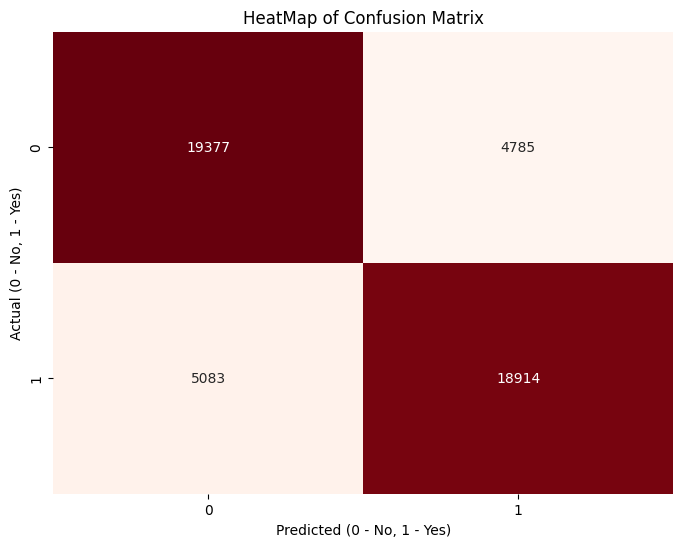

In [ ]:
cm = confusion_matrix(y_test_b, y_pred_b)
print("Confusion Matrix\n\n", cm, "\n")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='g', cbar=False)
plt.xlabel('Predicted (0 - No, 1 - Yes)')
plt.ylabel('Actual (0 - No, 1 - Yes)')
plt.title('HeatMap of Confusion Matrix')
plt.show()

**Accuracy Score**

In [ ]:
acc_score = accuracy_score(y_test_b, y_pred_b)
print("Accuracy Score: ", round(acc_score*100, 2), "%")

Accuracy Score:  79.51 %


**Adjusting based on Optimal Threshold**

In [ ]:
y_prob_b = logistic_classifier_b.predict_proba(X_test_b)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_b.values, y_prob_b)

roc_auc = roc_auc_score(y_test_b, y_prob_b)
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]

print("ROC-AUC Score: ", round(roc_auc*100, 2))
print("Optimal Threshold: ", round(optimal_threshold, 2))

y_pred_adjusted_b = (y_prob_b >= optimal_threshold).astype(int)

ROC-AUC Score:  87.75
Optimal Threshold:  0.49


**Accuracy after adjusting with threshold**

In [ ]:
acc_score = accuracy_score(y_test_b, y_pred_adjusted_b)
print("Accuracy Score: ", round(acc_score*100, 2), "%")

Accuracy Score:  79.54 %


**Inference on adjusting threshold**

1. Accuracy score is increased in this case unlike the previous case where the dataset is imbalanced.
2. Since, the dataset is already balanced here Accuracy increases.

### **Gaussian Naive Bayes Classification**

**Fitting and predicting using Gaussian Naive Bayes**

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)

y_pred = gnb.predict(X_test)

**Confusion Matrix**

Confusion Matrix

 [[15074  8974]
 [ 1897  4983]] 



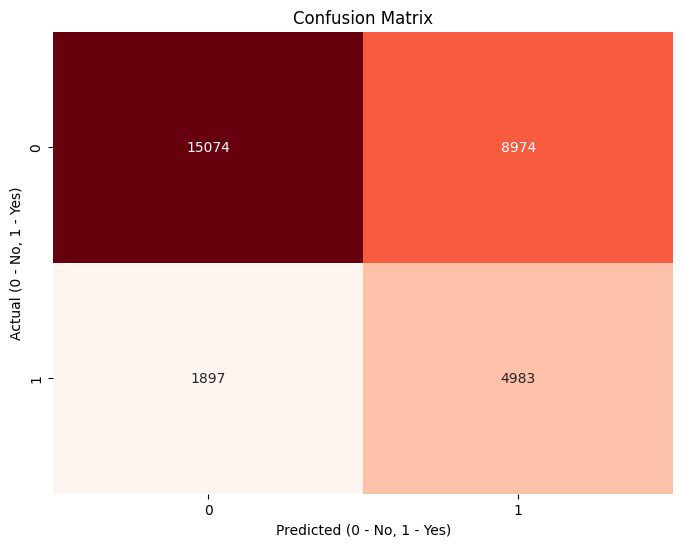

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n\n", cm, "\n")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='g', cbar=False)
plt.xlabel('Predicted (0 - No, 1 - Yes)')
plt.ylabel('Actual (0 - No, 1 - Yes)')
plt.title('Confusion Matrix')
plt.show()

**Classification report and Accuracy score**

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))
acc_score = accuracy_score(y_test, y_pred)
print("Accuracy Score: ", round(acc_score*100, 2), "%")

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.63      0.73     24048
           1       0.36      0.72      0.48      6880

    accuracy                           0.65     30928
   macro avg       0.62      0.68      0.61     30928
weighted avg       0.77      0.65      0.68     30928

Accuracy Score:  64.85 %


**ROC Curve and optimal threshold**

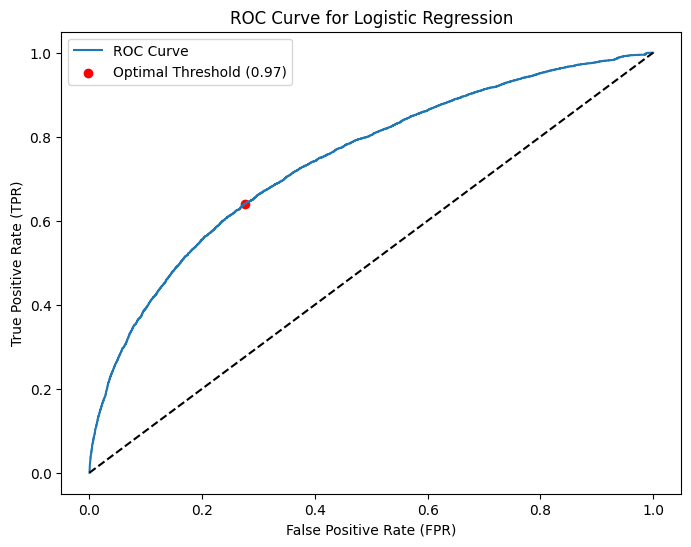

ROC-AUC Score:  74.32
Optimal Threshold:  0.97


In [ ]:
y_prob = gnb.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test.values, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Logistic Regression')

roc_auc = roc_auc_score(y_test, y_prob)
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]

plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], marker='o', color='red', label=f'Optimal Threshold ({optimal_threshold:.2f})')

plt.legend()
plt.show()

print("ROC-AUC Score: ", round(roc_auc*100, 2))
print("Optimal Threshold: ", round(optimal_threshold, 2))

y_pred_adjusted = (y_prob >= optimal_threshold).astype(int)

**Accuracy Score after adjusting threshold**

In [ ]:
acc_score = accuracy_score(y_test, y_pred_adjusted)
print("Accuracy Score: ", round(acc_score*100, 2), "%")

Accuracy Score:  70.57 %


**Inference on adjusted threshold score**

1. Gaussian Naive Bayes classifier bias is leaned towards the majority class.
2. The accuracy score increases due to the balancing of both the classes by the threshold and bias is leaning less towards majority class.

**Cross-Validation with k-folds**

1. Optimising with k = 3.

In [ ]:
k = 3

cv_scores = cross_val_score(gnb, X, y, cv=k)

mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", mean_cv_score)
print("Standard Deviation of CV Scores:", std_cv_score)

Cross-Validation Scores: [0.59196838 0.68664064 0.56773208]
Mean CV Score: 0.6154470316469737
Standard Deviation of CV Scores: 0.05130462465314318


**Inference after k-fold analysis**

1. 3-fold analysis produces scores that are close to the initial model accuracy, and one of the scores is higher than initial accuracy (at 2-fold). Hence, k-fold cross validation increases the accuracy.

**Test for overfit or underfit**

In [ ]:
print(f"Training set score: {gnb.score(X_train, y_train):0.4f}")
print(f"Testing set score: {gnb.score(X_test,y_test):.4f}")

Training set score: 0.6530
Testing set score: 0.6485


1. Since training set score is larger than testing set score, it causes over-fitting.
2. Since it is just a small difference in accuracy, It does not contribute to significant amount of over-fitting.

### **Gaussian Naive Bayes Classification with Balanced Dataset**

**Train Test Split with Balancing using OverSampler**

In [ ]:
X_b = dataset.drop(columns = ['RainTomorrow'])
y_b = dataset['RainTomorrow']

ros = RandomOverSampler()
X_b, y_b = ros.fit_resample(X_b, y_b)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size = 0.20, random_state = 0)

**Fitting the model**

In [ ]:
gnb_b = GaussianNB()
gnb_b.fit(X_train_b, y_train_b)

y_pred_b = gnb_b.predict(X_test_b)

**Confusion Matrix**

Confusion Matrix

 [[11372  7843]
 [ 4740 14573]] 



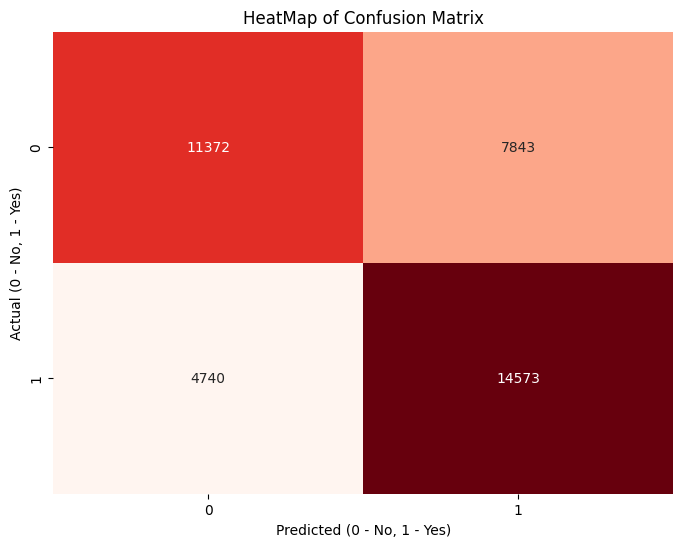

In [ ]:
cm = confusion_matrix(y_test_b, y_pred_b)
print("Confusion Matrix\n\n", cm, "\n")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='g', cbar=False)
plt.xlabel('Predicted (0 - No, 1 - Yes)')
plt.ylabel('Actual (0 - No, 1 - Yes)')
plt.title('HeatMap of Confusion Matrix')
plt.show()

**Accuracy Score**

In [ ]:
acc_score = accuracy_score(y_test_b, y_pred_b)
print("Accuracy Score: ", round(acc_score*100, 2), "%")

Accuracy Score:  67.34 %


**Adjusting based on Optimal Threshold**

In [ ]:
y_prob_b = gnb_b.predict_proba(X_test_b)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_b.values, y_prob_b)

roc_auc = roc_auc_score(y_test_b, y_prob_b)
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]

print("ROC-AUC Score: ", round(roc_auc*100, 2))
print("Optimal Threshold: ", round(optimal_threshold, 2))

y_pred_adjusted_b = (y_prob_b >= optimal_threshold).astype(int)

ROC-AUC Score:  75.0
Optimal Threshold:  0.99


**Accuracy after adjusting with threshold**

In [ ]:
acc_score = accuracy_score(y_test_b, y_pred_adjusted_b)
print("Accuracy Score: ", round(acc_score*100, 2), "%")

Accuracy Score:  68.67 %


**Inference on accuracy after threshold adjustment**

1. The accuracy increases due to the same bias being leaned towards majority class.
2. It does not produce a significant change because the dataset is almost well-balanced.